In [2]:
!ultralytics version

8.2.55


In [1]:
!git clone https://github.com/ultralytics/ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 30639, done.
remote: Counting objects: 100% (1095/1095), done.
remote: Compressing objects: 100% (685/685), done.
remote: Total 30639 (delta 703), reused 683 (delta 406), pack-reused 29544
Receiving objects: 100% (30639/30639), 15.82 MiB | 2.53 MiB/s, done.
Resolving deltas: 100% (21989/21989), done.


In [2]:
%cd ultralytics

[Errno 2] No such file or directory: 'ultralytics'
/home/areebadnankhan/code/work/Atheritia/Notebooks


In [3]:
!git reset --hard abd391b63338b79cebee808b6679498dcc94956f

HEAD is now at abd391b6 `ultralytics 8.2.55` adaptive `tflite_support` logic (#14385)


In [4]:
 #Download patch
!wget https://gist.githubusercontent.com/Y-T-G/8f4fc0b78a0a559a06fe84ae4f359e6e/raw/05a9086de3825e15ebef3830229273982c3ad9ec/add_head.patch

--2024-07-22 19:31:40--  https://gist.githubusercontent.com/Y-T-G/8f4fc0b78a0a559a06fe84ae4f359e6e/raw/05a9086de3825e15ebef3830229273982c3ad9ec/add_head.patch
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11258 (11K) [text/plain]
Saving to: ‘add_head.patch’

add_head.patch      100%[===================>]  10.99K  --.-KB/s    in 0s      

2024-07-22 19:31:41 (187 MB/s) - ‘add_head.patch’ saved [11258/11258]



In [5]:
!git apply add_head.patch

In [3]:
from ultralytics import YOLO
import torch
import copy


# Initialize pretrained model
#model = YOLO('yolov8n.pt')

model = YOLO("/home/areebadnankhan/code/work/Atheritia/All_models/yolov8n_3logos_22freezed_withBN.pt")

# Keep a copy of old state dict for sanity check
old_dict = copy.deepcopy(model.state_dict())

# We should freeze all but the last layer
model.state_dict().keys()

odict_keys(['model.model.0.conv.weight', 'model.model.0.bn.weight', 'model.model.0.bn.bias', 'model.model.0.bn.running_mean', 'model.model.0.bn.running_var', 'model.model.0.bn.num_batches_tracked', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.1.bn.num_batches_tracked', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv1.bn.num_batches_tracked', 'model.model.2.cv2.conv.weight', 'model.model.2.cv2.bn.weight', 'model.model.2.cv2.bn.bias', 'model.model.2.cv2.bn.running_mean', 'model.model.2.cv2.bn.running_var', 'model.model.2.cv2.bn.num_batches_tracked', 'model.model.2.m.0.cv1.conv.weight', 'model.model.2.m.0.cv1.bn.weight', 'model.model.2.m.0.cv1.bn.bias', 'model.model.2.m.0.cv1.bn.running_mean', 'model.model.2.m.0.cv1.bn.running_var', 'model.mod

In [4]:
# for name, module in model.model.named_modules():
#     print(f"Layer: {name}, Module: {module}")


In [5]:
# Add a callback to put the frozen layers in eval mode to prevent BN values
# from changing.
def put_in_eval_mode(trainer, n_layers=22):
  for i, (name, module) in enumerate(trainer.model.named_modules()):
    if name.endswith("bn") and int(name.split('.')[1]) < n_layers:
      module.eval()
      module.track_running_stats = False
      # print(name, " put in eval mode.")

In [6]:
model.add_callback("on_train_epoch_start", put_in_eval_mode)
model.add_callback("on_pretrain_routine_start", put_in_eval_mode)

In [7]:
def compare_dicts(state_dict1, state_dict2):
    # Compare the keys
    keys1 = set(state_dict1.keys())
    keys2 = set(state_dict2.keys())

    if keys1 != keys2:
        print("Models have different parameter names.")
        return False

    # Compare the values (weights)
    for key in keys1:
        if not torch.equal(state_dict1[key], state_dict2[key]):
            print(f"Weights for parameter '{key}' are different.")
            if "bn" in key and "22" not in key:
              state_dict1[key] = state_dict2[key]

In [8]:
new_model = YOLO("/home/areebadnankhan/code/work/Atheritia/All_models/yolov8n_5logos_22freezed_withBN.pt")

#new_model = YOLO("yolov8n.pt")

new_model.state_dict().items()

odict_items([('model.model.0.conv.weight', tensor([[[[-1.1523e-01, -1.0582e-02,  1.0693e-01],
          [-3.6816e-01,  3.3447e-02,  3.8745e-01],
          [-3.3716e-01, -1.3680e-02,  3.1201e-01]],

         [[-1.4233e-01,  9.7656e-03,  1.5222e-01],
          [-4.8999e-01,  2.7908e-02,  4.6021e-01],
          [-3.7256e-01, -2.7542e-03,  3.4814e-01]],

         [[-4.9866e-02, -1.4900e-02,  2.4887e-02],
          [-2.1375e-01,  3.2898e-02,  1.9385e-01],
          [-1.5344e-01,  3.1113e-02,  1.5649e-01]]],


        [[[ 1.2283e-02,  1.8890e-02,  8.2321e-03],
          [-2.7218e-03, -2.3987e-02,  2.9926e-03],
          [-1.7059e-02, -1.4148e-01, -1.7426e-02]],

         [[-9.5062e-03,  1.2146e-02,  8.6975e-04],
          [-7.3242e-03, -2.6993e-02, -5.9357e-03],
          [-2.0844e-02, -1.4062e-01, -2.2461e-02]],

         [[-1.9436e-03,  4.3182e-03, -3.6392e-03],
          [ 3.4027e-03, -8.4229e-03,  6.2981e-03],
          [ 1.0201e-02, -6.1340e-02,  1.8524e-02]]],


        [[[-1.0460e-02,

In [9]:
# for name, module in new_model.model.named_modules():
#     print(f"Layer: {name}, Module: {module}")


In [10]:
# Compare the dicts. Changes should only be in layer 21 and above
compare_dicts(old_dict, new_model.state_dict())

Weights for parameter 'model.model.22.cv3.2.2.bias' are different.
Weights for parameter 'model.model.22.cv2.2.2.weight' are different.
Weights for parameter 'model.model.22.cv2.0.0.bn.bias' are different.
Weights for parameter 'model.model.22.cv2.2.1.bn.running_var' are different.
Weights for parameter 'model.model.22.cv3.0.1.bn.bias' are different.
Weights for parameter 'model.model.22.cv2.0.1.bn.weight' are different.
Weights for parameter 'model.model.22.cv2.1.1.bn.running_mean' are different.
Weights for parameter 'model.model.22.cv2.0.2.bias' are different.
Weights for parameter 'model.model.22.cv2.0.0.bn.weight' are different.
Weights for parameter 'model.model.22.cv2.0.0.bn.running_var' are different.
Weights for parameter 'model.model.22.cv2.2.0.bn.running_var' are different.
Weights for parameter 'model.model.22.cv2.0.1.bn.bias' are different.
Weights for parameter 'model.model.22.cv3.0.0.bn.weight' are different.
Weights for parameter 'model.model.22.cv2.1.1.bn.bias' are dif

In [11]:
new_state_dict = dict()

In [12]:
#  Increment the head number by 1 in the state_dict
for k, v in new_model.state_dict().items():
  if k.startswith("model.model.22"):
    new_state_dict[k.replace("model.22", "model.23")] = v
  # else:
  #   new_state_dict[k] = v

In [13]:
new_state_dict

{'model.model.23.cv2.0.0.conv.weight': tensor([[[[-1.5454e-01,  2.0398e-01,  3.3569e-01],
           [-3.9160e-01,  4.7607e-01,  3.4985e-01],
           [ 7.0984e-02,  2.8613e-01, -5.4321e-02]],
 
          [[ 2.3911e-02, -6.6162e-02, -5.3711e-02],
           [ 9.2926e-03, -1.8457e-01,  2.8519e-02],
           [ 3.0444e-01, -8.0750e-02,  1.3770e-01]],
 
          [[-2.3865e-01, -2.1240e-02, -1.0693e-01],
           [ 2.0737e-02,  1.3031e-02, -3.1796e-03],
           [ 1.9932e-04, -6.4575e-02, -1.0876e-01]],
 
          ...,
 
          [[-1.1101e-02,  4.8035e-02,  1.8811e-01],
           [-3.4576e-02, -1.9641e-01, -3.3691e-01],
           [-3.3234e-02, -6.9458e-02, -3.1494e-02]],
 
          [[ 2.4658e-01, -1.1993e-01,  7.8308e-02],
           [-4.4116e-01,  4.8332e-03,  1.6980e-01],
           [-4.1724e-01, -2.9077e-01,  4.7339e-01]],
 
          [[ 5.0659e-02,  7.4524e-02, -1.3893e-02],
           [ 3.3618e-01, -5.4199e-02, -1.0876e-01],
           [ 5.0293e-01,  5.9235e-02,  1.6394e

In [14]:
new_state_dict['model.model.23.cv2.0.0.conv.weight'].shape


torch.Size([64, 64, 3, 3])

In [15]:
# Save the current state_dict
torch.save(new_state_dict, "yolov8n_lp.pth")

In [16]:
from ultralytics import YOLO
import torch

In [17]:
import os

# Get the current working directory
current_directory = os.getcwd()

print("Current working directory:", current_directory)

Current working directory: /home/areebadnankhan/code/work/Atheritia/Notebooks


In [16]:
# Edit this to the number of new classes you added
added_classes = 5 # Added 2 new classes.
nc = 3 + added_classes # Total no. of classes

# Update yaml with the number of added_classes
!sed -i "52s/.*/  - \[\[15, 18, 21\], 1, Detect, \[{added_classes}\]\]/g" ultralytics/cfg/models/v8/yolov8n-2xhead.yaml
!sed -i "5s/.*/nc: {nc}/g" ultralytics/cfg/models/v8/yolov8n-2xhead.yaml

In [18]:
#model_2 = YOLO('ultralytics/cfg/models/v8/yolov8n-2xhead.yaml', task="detect").load('yolov8n.pt')

model_2 = YOLO('ultralytics/cfg/models/v8/yolov8n-2xhead.yaml', task="detect").load('/home/areebadnankhan/code/work/Atheritia/All_models/yolov8n_3logos_22freezed_withBN.pt')

Transferred 355/440 items from pretrained weights


In [19]:
model_2

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [20]:
state_dict = torch.load("yolov8n_lp.pth")

# Load state_dict of the custom trained model head. Layer 23.
model_2.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['model.model.0.conv.weight', 'model.model.0.bn.weight', 'model.model.0.bn.bias', 'model.model.0.bn.running_mean', 'model.model.0.bn.running_var', 'model.model.1.conv.weight', 'model.model.1.bn.weight', 'model.model.1.bn.bias', 'model.model.1.bn.running_mean', 'model.model.1.bn.running_var', 'model.model.2.cv1.conv.weight', 'model.model.2.cv1.bn.weight', 'model.model.2.cv1.bn.bias', 'model.model.2.cv1.bn.running_mean', 'model.model.2.cv1.bn.running_var', 'model.model.2.cv2.conv.weight', 'model.model.2.cv2.bn.weight', 'model.model.2.cv2.bn.bias', 'model.model.2.cv2.bn.running_mean', 'model.model.2.cv2.bn.running_var', 'model.model.2.m.0.cv1.conv.weight', 'model.model.2.m.0.cv1.bn.weight', 'model.model.2.m.0.cv1.bn.bias', 'model.model.2.m.0.cv1.bn.running_mean', 'model.model.2.m.0.cv1.bn.running_var', 'model.model.2.m.0.cv2.conv.weight', 'model.model.2.m.0.cv2.bn.weight', 'model.model.2.m.0.cv2.bn.bias', 'model.model.2.m.0.cv2.bn.running_mean', 'model.model

In [21]:
%cd ..

/home/areebadnankhan/code/work/Atheritia


In [22]:
# Output of COCO model
model_coco = YOLO("/home/areebadnankhan/code/work/Atheritia/All_models/yolov8n_3logos_22freezed_withBN.pt")

# For consistency
model_coco.model.names = {k:k for k in model_coco.names.keys()}

result_coco = model_coco.predict("/home/areebadnankhan/code/work/Atheritia/merged_images/pic5.jpg")[0]


image 1/1 /home/areebadnankhan/code/work/Atheritia/merged_images/pic5.jpg: 640x640 1 1, 137.5ms
Speed: 3.5ms preprocess, 137.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


In [23]:
# Output of custom LP model
model_lp = YOLO("/home/areebadnankhan/code/work/Atheritia/All_models/yolov8n_5logos_22freezed_withBN.pt")

# For plotting consistency, change all class names to class numbers
model_lp.model.names = {k:k for k in model_lp.names.keys()}

result_lp = model_lp.predict("/home/areebadnankhan/code/work/Atheritia/merged_images/pic5.jpg")[0]


image 1/1 /home/areebadnankhan/code/work/Atheritia/merged_images/pic5.jpg: 640x640 2 0s, 136.7ms
Speed: 4.2ms preprocess, 136.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


In [24]:
# Output of the new model
result_merged = model_2.predict("/home/areebadnankhan/code/work/Atheritia/merged_images/pic5.jpg")[0]


torch.Size([1, 7, 8400])
torch.Size([1, 9, 8400])
image 1/1 /home/areebadnankhan/code/work/Atheritia/merged_images/pic5.jpg: 640x640 1 1, 2 3s, 154.7ms
Speed: 5.5ms preprocess, 154.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


In [25]:
print(result_merged)

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7'}
obb: None
orig_img: array([[[ 49,  33,  50],
        [ 49,  33,  50],
        [ 51,  36,  50],
        ...,
        [ 35,  35,  35],
        [ 35,  35,  35],
        [ 35,  35,  35]],

       [[ 56,  42,  54],
        [ 49,  34,  48],
        [ 50,  35,  49],
        ...,
        [ 35,  35,  35],
        [ 35,  35,  35],
        [ 35,  35,  35]],

       [[ 42,  30,  36],
        [ 50,  37,  45],
        [ 48,  34,  46],
        ...,
        [ 34,  34,  34],
        [ 34,  34,  34],
        [ 34,  34,  34]],

       ...,

       [[ 26,  20,  37],
        [ 26,  20,  37],
        [ 26,  20,  37],
        ...,
        [240, 228, 226],
        [240, 228, 226],
        [240, 228, 226]],

       [[ 25,  19,  36],
        [ 26,  20,  37],
        [ 26,  20,  37],
        ...,
        [240

In [26]:
import matplotlib.pyplot as plt
import numpy as np


In [27]:
def show_output(images):
    image = np.vstack(images)
    fig = plt.figure()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    fig.set_size_inches((5,15))
    ax.imshow(image[...,::-1])

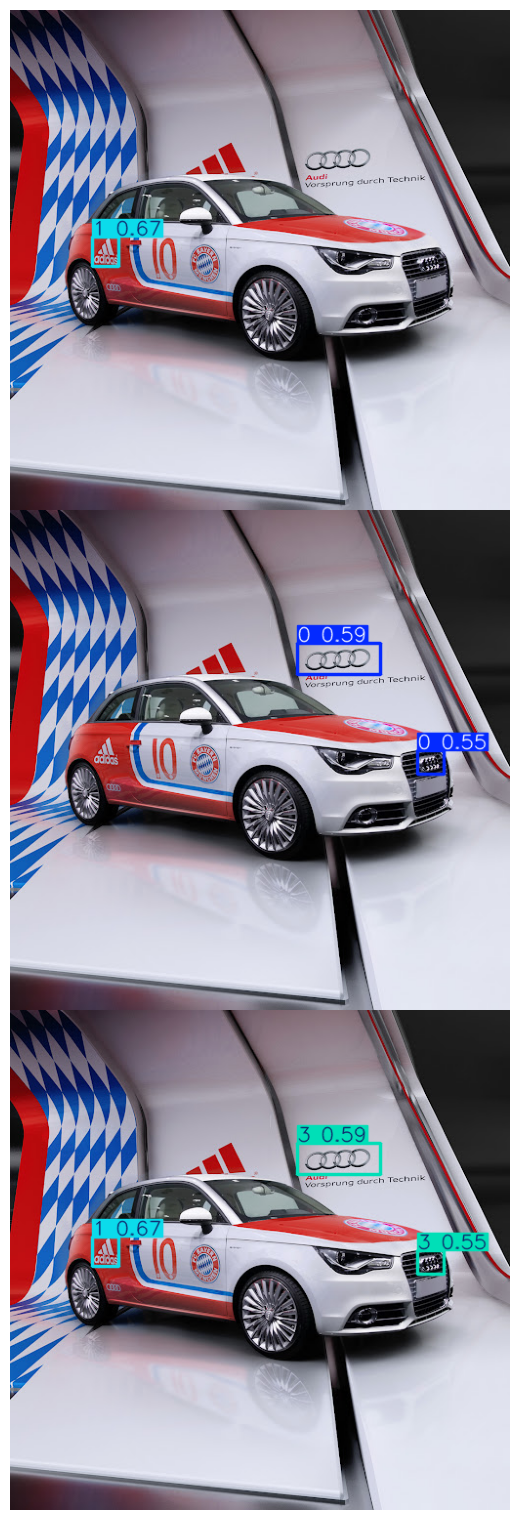

In [28]:
show_output([result_coco.plot(), result_lp.plot(), result_merged.plot()])

In [29]:
import os

# Get the current working directory
current_directory = os.getcwd()

print("Current working directory:", current_directory)

Current working directory: /home/areebadnankhan/code/work/Atheritia


In [27]:
cd ..

/home/areebadnankhan/code/work/Atheritia


In [31]:
validation_results = model_2.val(data="Datasets/5_logo_dataset/dataset/data.yaml")

Ultralytics YOLOv8.2.55 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (11th Gen Intel Core(TM) i5-1135G7 2.40GHz)


val: Scanning /home/areebadnankhan/code/work/Atheritia/Datasets/5_logo_dataset/dataset/valid/labels... 728 images, 0 backgrounds, 0 corrupt: 100%|██████████| 728/728 [00:00<00:00, 1844.06it/s]


val: New cache created: /home/areebadnankhan/code/work/Atheritia/Datasets/5_logo_dataset/dataset/valid/labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   2%|▏         | 1/46 [00:03<02:56,  3.93s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   4%|▍         | 2/46 [00:07<02:51,  3.91s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   7%|▋         | 3/46 [00:11<02:48,  3.92s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   9%|▊         | 4/46 [00:15<02:42,  3.86s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 5/46 [00:19<02:36,  3.82s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  13%|█▎        | 6/46 [00:23<02:33,  3.83s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 7/46 [00:26<02:26,  3.76s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  17%|█▋        | 8/46 [00:29<02:16,  3.58s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|█▉        | 9/46 [00:31<01:53,  3.07s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 10/46 [00:33<01:37,  2.71s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  24%|██▍       | 11/46 [00:35<01:25,  2.45s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  26%|██▌       | 12/46 [00:37<01:17,  2.27s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  28%|██▊       | 13/46 [00:39<01:10,  2.14s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  30%|███       | 14/46 [00:41<01:06,  2.06s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 15/46 [00:43<01:02,  2.00s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  35%|███▍      | 16/46 [00:44<00:58,  1.96s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  37%|███▋      | 17/46 [00:46<00:56,  1.96s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  39%|███▉      | 18/46 [00:48<00:54,  1.96s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  41%|████▏     | 19/46 [00:51<00:55,  2.06s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  43%|████▎     | 20/46 [00:53<00:55,  2.13s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  46%|████▌     | 21/46 [00:55<00:54,  2.18s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  48%|████▊     | 22/46 [00:58<00:53,  2.22s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 23/46 [01:00<00:51,  2.24s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  52%|█████▏    | 24/46 [01:02<00:49,  2.25s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  54%|█████▍    | 25/46 [01:04<00:47,  2.27s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  57%|█████▋    | 26/46 [01:07<00:45,  2.28s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  59%|█████▊    | 27/46 [01:09<00:43,  2.29s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  61%|██████    | 28/46 [01:11<00:41,  2.30s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  63%|██████▎   | 29/46 [01:14<00:39,  2.30s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  65%|██████▌   | 30/46 [01:16<00:36,  2.31s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 31/46 [01:18<00:34,  2.31s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|██████▉   | 32/46 [01:21<00:32,  2.31s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  72%|███████▏  | 33/46 [01:23<00:30,  2.31s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  74%|███████▍  | 34/46 [01:25<00:27,  2.31s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▌  | 35/46 [01:28<00:25,  2.30s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 36/46 [01:30<00:23,  2.30s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  80%|████████  | 37/46 [01:32<00:20,  2.30s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  83%|████████▎ | 38/46 [01:34<00:18,  2.30s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▍ | 39/46 [01:37<00:16,  2.30s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  87%|████████▋ | 40/46 [01:39<00:13,  2.31s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 41/46 [01:41<00:11,  2.29s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  91%|█████████▏| 42/46 [01:43<00:08,  2.17s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  93%|█████████▎| 43/46 [01:46<00:06,  2.23s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  96%|█████████▌| 44/46 [01:49<00:05,  2.60s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  98%|█████████▊| 45/46 [01:53<00:02,  2.90s/it]

torch.Size([16, 7, 5292])
torch.Size([16, 9, 5292])


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [01:54<00:00,  2.50s/it]

torch.Size([8, 7, 5292])
torch.Size([8, 9, 5292])


                   all        728       1084      0.675      0.474      0.516      0.238
                     3        282        383      0.759      0.433      0.467      0.174
                     4        114        120      0.549      0.517      0.528      0.209
                     5        150        151      0.679       0.55      0.616      0.305
                     6        141        239      0.485      0.118      0.123     0.0577
                     7        181        191      0.901      0.754      0.847      0.442
Speed: 2.1ms preprocess, 107.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /home/areebadnankhan/code/work/Atheritia/ultralytics/runs/detect/val6


In [32]:
model_2.names

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7'}

In [33]:
model_2.predict("/home/areebadnankhan/code/work/Atheritia/Datasets/5_logo_dataset/dataset/valid/images", save=True)


torch.Size([1, 7, 5040])
torch.Size([1, 9, 5040])
image 1/728 /home/areebadnankhan/code/work/Atheritia/Datasets/5_logo_dataset/dataset/valid/images/vid0070.png: 384x640 2 7s, 96.6ms
torch.Size([1, 7, 5040])
torch.Size([1, 9, 5040])
image 2/728 /home/areebadnankhan/code/work/Atheritia/Datasets/5_logo_dataset/dataset/valid/images/vid0071.png: 384x640 3 7s, 90.0ms
torch.Size([1, 7, 5040])
torch.Size([1, 9, 5040])
image 3/728 /home/areebadnankhan/code/work/Atheritia/Datasets/5_logo_dataset/dataset/valid/images/vid0072.png: 384x640 1 7, 87.6ms
torch.Size([1, 7, 5040])
torch.Size([1, 9, 5040])
image 4/728 /home/areebadnankhan/code/work/Atheritia/Datasets/5_logo_dataset/dataset/valid/images/vid0073.png: 384x640 1 7, 90.3ms
torch.Size([1, 7, 5040])
torch.Size([1, 9, 5040])
image 5/728 /home/areebadnankhan/code/work/Atheritia/Datasets/5_logo_dataset/dataset/valid/images/vid0074.png: 384x640 (no detections), 91.7ms
torch.Size([1, 7, 5040])
torch.Size([1, 9, 5040])
image 6/728 /home/areebadnankh